## Setup

In [1]:
from itertools import product
import mplhep as hep
import ROOT
ROOT.gStyle.SetOptStat(0);
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from Gaugi import GeV
plt.style.use(hep.style.ROOT)
import warnings
warnings.filterwarnings('ignore')
from argparse import ArgumentParser
from typing import List
import joblib
import seaborn as sns
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 15,10
%matplotlib inline

from packages.plotting import var_infos, plot_distribution
import packages.utils as utils
from packages.constants import CRITERIA_CONF_NAMES, HOME_PATH

Welcome to JupyROOT 6.16/00
Using all sub packages with ROOT dependence


In [10]:
float('None')

ValueError: could not convert string to float: 'None'

In [2]:
def joint_plots(data, x, y, et_cut=None, ylim=None,
                      xlim=None, xlabel=None, ylabel=None, data_label=None, criterion=None,
                      title=None, cmap=None, marg_color=None, figsize=None):
    if (data_label is not None) and (data_label != 'all') and (criterion is not None):
        data_labeling_func = utils.LABEL_UTILITIES[data_label]
        data = data[data_labeling_func(data, f'el_lh{criterion}')]
    if et_cut is not None:
        data = data[data[var_infos['et']['l2_calo_col']] < et_cut]
    jplot = sns.jointplot(data=data, x=x, y=y, kind='hist', 
                  marginal_kws=dict(thresh=0, color=marg_color),
                  marginal_ticks=True, xlim=xlim, ylim=ylim,
                  joint_kws=dict(thresh=0, cmap=cmap, cbar=True, cbar_kws=dict(orientation="vertical")))
    
    plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
    # get the current positions of the joint ax and the ax for the marginal x
    pos_joint_ax = jplot.ax_joint.get_position()
    pos_marg_x_ax = jplot.ax_marg_x.get_position()
    pos_marg_y_ax = jplot.ax_marg_y.get_position()
    # reposition the joint ax so it has the same width as the marginal x ax
    jplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
    # reposition the colorbar using new x positions and y positions of the joint ax
    
    if xlabel is not None:
        jplot.ax_joint.set_xlabel(xlabel)
    if ylabel is not None:
        jplot.ax_joint.set_ylabel(ylabel)
    
    jplot.figure.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])
    jplot.figure.patch.set_facecolor('white')
    jplot.figure.suptitle(title, fontsize='xx-large')
    if figsize is not None:
        jplot.figure.set_figwidth(figsize[0])
        jplot.figure.set_figheight(figsize[1])
    jplot.figure.text(0.7, 0.9, f'Samples:\n{len(data)}', fontsize=14,
                        verticalalignment='top', wrap=True)
    jplot.figure.tight_layout()
    return jplot

## Parameters

In [3]:
# DATASETS
# boosted: mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2
# data17: data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins

# MODELS'
# tunings/TrigL2_20180125_v8
# tunings/TrigL2_20210907_v12 (v8.1-2)
# tunings/TrigL2_20210306_v10
# tunings/TrigL2_20220822_v10.1
# tunings/TrigL2_20220704_v20
# tunings/TrigL2_20220802_v20.1

# VARS: et eta mu pt dr

datasetpath = os.path.join(HOME_PATH, 
   'data/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2')

modelpaths = [
    'tunings/TrigL2_20180125_v8'
    #'tunings/TrigL2_20210907_v12 (v8.1-2)',
    #'tunings/TrigL2_20220704_v20',
    #'tunings/TrigL2_20220802_v20.1',
    #'tunings/TrigL2_20210306_v10',
    #'tunings/TrigL2_20220822_v10.1'
]

output_dir = 'analysis/jointplot_test'
plot_vars = ['dr']#['et', 'eta', 'pt', 'mu', 'dr']
data_labels = ['electron']
criteria = ['tight'] #list(CRITERIA_CONF_NAMES.keys())
et_cut=300.0

dev = False
log = False

# Initializing logger
plot_logger = utils.get_logger('plot_vars_distributions', file=log)

## Getting models

In [4]:
plot_logger.info('Getting models')
trigger_strategies = []
aux_conf_name = CRITERIA_CONF_NAMES['tight']
for modelpath in modelpaths:
    confpath = os.path.join(modelpath, aux_conf_name)
    env = ROOT.TEnv(confpath)
    ringer_version = env.GetValue("__version__", '')
    ringer_name = f'ringer_{ringer_version}'
    trigger_strategies.append(ringer_name)

2022-09-02 11:28:57,666 - Getting models


## Plotting

2022-09-02 11:28:57,714 - Loading: ringer_v8.parquet
2022-09-02 11:28:57,977 - Plotting electron tight var dr for ringer_v8


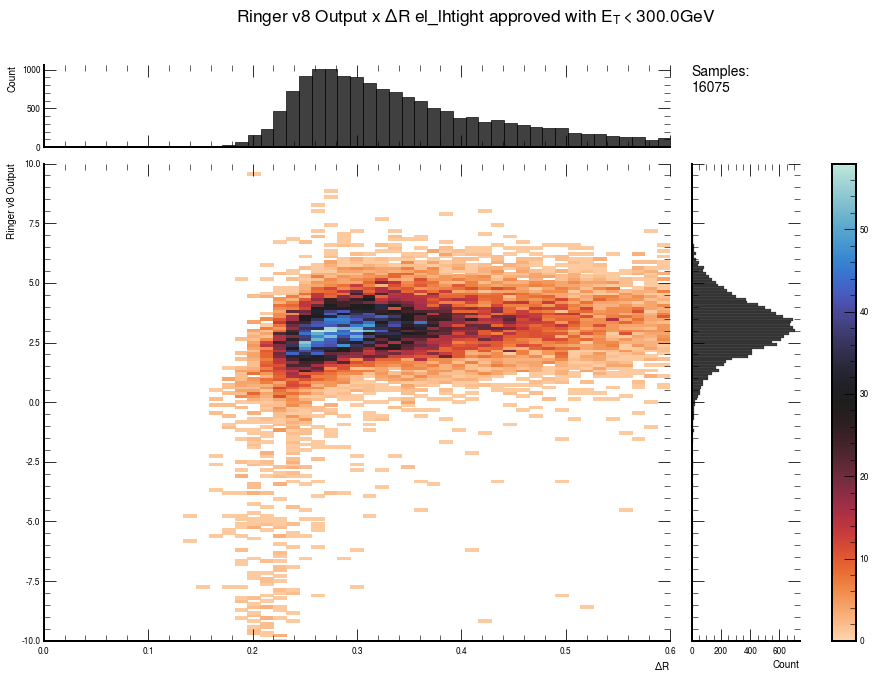

In [5]:
plots = dict()
xlims = dict(pt=(0,300), et=(0,300), dr=(0,0.6), mu=(0,100), eta=(-2.5,2.5))
ylims = dict(pt=(-25,25), et=(-20,20), dr=(-10,10), mu=(-20,20), eta=(-20,20))
for trig_strat in trigger_strategies:
    plots[trig_strat] = dict()
    parquet_file = trig_strat + '.parquet'
    chainpath = os.path.join(datasetpath, 'simulated_chains', parquet_file)
    if dev:
        chainpath = os.path.join(chainpath, f'{trig_strat}_et4_eta4.parquet')
    plot_logger.info(f'Loading: {parquet_file}')
    data = pd.read_parquet(chainpath)
    # Casting variables to GeV (They come in MeV)
    data[var_infos['pt']['col']] = data[var_infos['pt']['col']]/GeV
    data[var_infos['et']['col']] = data[var_infos['et']['col']]/GeV
    data[var_infos['et']['l2_calo_col']] = data[var_infos['et']['l2_calo_col']]/GeV
    for var, data_label, criterion in product(plot_vars, data_labels, criteria):
        plot_logger.info(f'Plotting {data_label} {criterion} var {var} for {trig_strat}')
        strat_name = trig_strat.capitalize().replace('_', ' ')
        text_label = var_infos[var]["label"].replace('#', '\\')

        if data_label == 'electron':
            title = fr'{strat_name} Output x ${text_label}$ el_lh{criterion} approved'
        elif data_label == 'jet':
            title = fr'{strat_name} Output x ${text_label}$ el_lh{criterion} reproved'
        elif data_label == 'all':
            title = fr'{strat_name} Output x ${text_label}$'

        if type(et_cut) is float:
            et_cut = round(et_cut, 2)
            title += f' with $E_T < {et_cut} GeV$'

        jplot = plot_distribution(data, y=f'{trig_strat}_{criterion}_output', x=var_infos[var]['col'], ylim=ylims[var],
                                    data_label=data_label, criterion=criterion, xlabel=fr'${text_label}$', xlim=xlims[var],
                                    ylabel=f'{trig_strat.capitalize().replace("_", " ")} Output', et_cut=et_cut,
                                    title = title, cmap="icefire_r", marg_color='black', figsize=(15,10))
        # jplot.ax_joint.text(0.05, 0.95, f'Samples: {len(data)}', transform=fig.axes[0].transAxes, fontsize=14,
        #                     verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plot_output_dir = os.path.join(output_dir, f'output_distributions_{data_label}', var)
        plot_name = f'{var}_{trig_strat}_{data_label}_{criterion}_distribution_et_cut_{et_cut}'
        if not os.path.exists(plot_output_dir):
            os.makedirs(plot_output_dir)
        jplot.figure.savefig(os.path.join(plot_output_dir, plot_name + '.png'), transparent=False, facecolor='white', dpi=300)
        #joblib.dump((fig, axes), os.path.join(plot_output_dir, plot_name + '.joblib'))
        #plots[trig_strat][plot_name] = (fig, axes)

In [6]:
plt.close('all')

In [7]:
plot_logger.info('Finished')

2022-09-02 11:29:00,934 - Finished
